In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
train_df = pd.read_csv('/content/drive/My Drive/Analytics_Vidhya/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/Analytics_Vidhya/test.csv')
transaction_df = pd.read_csv('/content/drive/My Drive/Analytics_Vidhya/transactions.csv')

In [6]:
print(train_df.shape)
print(test_df.shape)
print(transaction_df.shape)

(67200, 4)
(5900, 5)
(2266100, 11)


In [7]:
import numpy as np

# Only keep needed dbd
seq_dbd = list(range(1, 16))
transactions_filt = transaction_df[transaction_df['dbd'].isin(seq_dbd)]

# Prepare pivot table to quickly fetch historical values as columns
pivot = transactions_filt.pivot_table(
    index=['srcid', 'destid', 'doj'],
    columns='dbd',
    values=['cumsum_seatcount', 'cumsum_searchcount'],
    fill_value=0
)
pivot.columns = [f"{v}_dbd{dbd}" for v, dbd in pivot.columns] # Flatten columns

pivot.reset_index(inplace=True)

df = pd.merge(train_df, pivot, how='left', on=['srcid', 'destid', 'doj'])
# Collect feature columns in correct sequence order
seq_cols = []
for feat in ['cumsum_seatcount', 'cumsum_searchcount']:
    seq_cols += [f"{feat}_dbd{dbd}" for dbd in range(15, 0, -1)]

# Shape into 3D array for LSTM: (samples, timesteps, features)
X_raw  = df[seq_cols].values.reshape(len(df), 15, 2)
y = df['final_seatcount'].values

In [8]:
from sklearn.model_selection import train_test_split

X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_raw, y, test_size=0.2, shuffle=False
)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_2d = X_train_raw.reshape(-1, X_train_raw.shape[2])
X_val_2d = X_val_raw.reshape(-1, X_val_raw.shape[2])

scaler.fit(X_train_2d)
X_train_scaled = scaler.transform(X_train_2d).reshape(X_train_raw.shape)
X_val_scaled = scaler.transform(X_val_2d).reshape(X_val_raw.shape)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras

SEQUENCE_LENGTH = 15
model = Sequential([
    LSTM(50, input_shape=(SEQUENCE_LENGTH, 2), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)  # Regression output
])
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='mean_squared_error')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
from keras.callbacks import ModelCheckpoint
epochs = 30
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_15.keras',
                            verbose=1, save_best_only=True)

history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=epochs, batch_size=32, callbacks=[checkpointer], verbose=1)
print("Model training complete.")

Epoch 1/30
1674/1680 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1685979.2500
Epoch 1: val_loss improved from inf to 802459.00000, saving model to saved_models/weights.best.from_scratch_15.keras
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 1683407.2500 - val_loss: 802459.0000
Epoch 2/30
1673/1680 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 656908.7500
Epoch 2: val_loss improved from 802459.00000 to 736201.31250, saving model to saved_models/weights.best.from_scratch_15.keras
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 656819.3125 - val_loss: 736201.3125
Epoch 3/30
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 550799.3750
Epoch 3: val_loss improved from 736201.31250 to 596698.06250, saving model to saved_models/weights.best.from_scratch_15.keras
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 550803.3125 - val_loss: 596698.0625
Epoch 4/30
1673/1680 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 468572.6562
Epoch 4: val_loss improved from 596698.06250 to 489972.71875, saving 

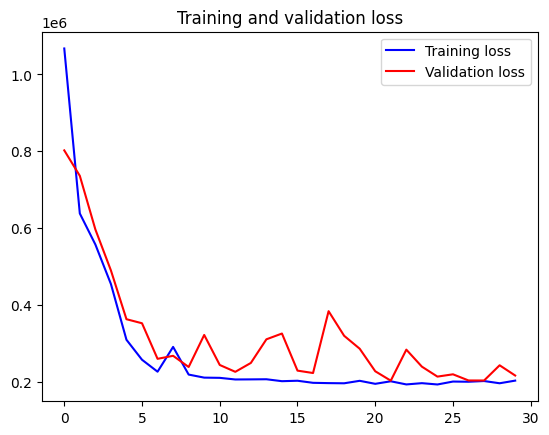

In [12]:
model.load_weights('saved_models/weights.best.from_scratch_15.keras')
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(epochs)
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
## Test data transformation
seq_dbd = list(range(1, 16))
transactions_filt = transaction_df[transaction_df['dbd'].isin(seq_dbd)]

# Prepare pivot table to quickly fetch historical values as columns
pivot = transactions_filt.pivot_table(
    index=['srcid', 'destid', 'doj'],
    columns='dbd',
    values=['cumsum_seatcount', 'cumsum_searchcount'],
    fill_value=0
)
pivot.columns = [f"{v}_dbd{dbd}" for v, dbd in pivot.columns] # Flatten columns

pivot.reset_index(inplace=True)

df_test = pd.merge(test_df, pivot, how='left', on=['srcid', 'destid', 'doj'])
# Collect feature columns in correct sequence order
seq_cols = []
for feat in ['cumsum_seatcount', 'cumsum_searchcount']:
    seq_cols += [f"{feat}_dbd{dbd}" for dbd in range(15, 0, -1)]

# Shape into 3D array for LSTM: (samples, timesteps, features)
X_raw_test  = df_test[seq_cols].values.reshape(len(df_test), 15, 2)
y_test = df_test['final_seatcount'].values
X_test_2d = X_raw_test.reshape(-1, X_raw_test.shape[2])
X_test_scaled = scaler.transform(X_test_2d).reshape(X_raw_test.shape)

In [28]:
from sklearn.metrics import mean_squared_error

# Make predictions on training and validation data
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Calculate Normalized RMSE
normalized_rmse_train = train_rmse / np.mean(y_train)
normalized_rmse_valid = val_rmse / np.mean(y_val)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Training Normalized RMSE: {normalized_rmse_train:.2f}")
print(f"Validation Normalized RMSE: {normalized_rmse_valid:.2f}")

1680/1680 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training RMSE: 373.13
Validation RMSE: 450.57
Training Normalized RMSE: 0.19
Validation Normalized RMSE: 0.20


In [29]:
y_test_pred = model.predict(X_test_scaled)

185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [30]:
# Calculate the relative RMSE for the y_test
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
normalized_rmse_test = test_rmse / np.mean(y_test)

print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test Normalized RMSE: {normalized_rmse_test:.2f}")

Test RMSE: 9.99
Test Normalized RMSE: 0.17
